<a href="https://colab.research.google.com/github/edmenciab733/hackaton2023/blob/main/diagnostico_trastornos_edgar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install -q bitsandbytes datasets accelerate loralib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 KB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 24.6 MB/s eta 0:00:00


In [136]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 54.6 MB/s eta 0:00:00


In [133]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
import numpy as np
from datasets import load_metric
from transformers import Trainer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [155]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
data = pd.read_excel("Sintomas.xlsx")

In [83]:
labelencoder = LabelEncoder()
labelencoder.fit(data['Padecimiento'])
data['Padecimiento_Cat'] = labelencoder.transform(data['Padecimiento'])

In [85]:
labelencoder.transform(['Enuresis'])

array([0])

In [111]:
id2label = {}
label2id = {}
for i in labelencoder.classes_:
   id = labelencoder.transform([i])[0]
   id = str(id)
   id2label[id] = i
   label2id[i] = id

In [112]:
id2label, label2id

({'0': 'Enuresis',
  '1': 'Transtorno del sueño',
  '2': 'Trastorno Depresivo Mayor',
  '3': 'Trastorno de Ansiedad Debido a Otra Afección Médica',
  '4': 'Trastorno de Ansiedad Generalizada',
  '5': 'Trastorno de Ansiedad Social (Fobia Social)',
  '6': 'Trastorno por Abuso de Sustancias',
  '7': 'Trastornos de la conducta alimentaria no especificados',
  '8': 'Trastornos de la personalidad antisocial',
  '9': 'Trastornos de la personalidad borderline',
  '10': 'Trastornos de la personalidad esquizoide',
  '11': 'Trastornos de la personalidad esquizotípica',
  '12': 'Trastornos de la personalidad histriónica',
  '13': 'Trastornos de la personalidad narcisista',
  '14': 'Trastornos de la personalidad paraoide'},
 {'Enuresis': '0',
  'Transtorno del sueño': '1',
  'Trastorno Depresivo Mayor': '2',
  'Trastorno de Ansiedad Debido a Otra Afección Médica': '3',
  'Trastorno de Ansiedad Generalizada': '4',
  'Trastorno de Ansiedad Social (Fobia Social)': '5',
  'Trastorno por Abuso de Sustan

In [94]:
target_nro = len(labelencoder.classes_)
target_nro

15

In [95]:
data.head()

,Síntoma,Padecimiento,Padecimiento_Cat
0,Uso excesivo de sustancias a pesar de los prob...,Trastorno por Abuso de Sustancias,6
1,El paciente menciona que ha tratado de relajar...,Transtorno del sueño,1
2,Preocupación constante por la posibilidad de c...,Trastorno de Ansiedad Social (Fobia Social),5
3,No puede controlar su consumo de drogas o alcohol,Trastorno por Abuso de Sustancias,6
4,La preocupación del paciente por su peso o apa...,Trastornos de la conducta alimentaria no espec...,7


In [96]:
data.Padecimiento.value_counts()

Trastornos de la personalidad narcisista                  118
Trastornos de la personalidad histriónica                 100
Trastornos de la personalidad borderline                   98
Trastornos de la personalidad antisocial                   74
Trastornos de la personalidad esquizotípica                70
Enuresis                                                   68
Trastornos de la personalidad esquizoide                   47
Trastorno de Ansiedad Social (Fobia Social)                40
Trastorno de Ansiedad Generalizada                         40
Trastornos de la personalidad paraoide                     37
Trastornos de la conducta alimentaria no especificados     30
Trastorno Depresivo Mayor                                  30
Transtorno del sueño                                       23
Trastorno por Abuso de Sustancias                          20
Trastorno de Ansiedad Debido a Otra Afección Médica        19
Name: Padecimiento, dtype: int64

In [97]:
data = data.sample(frac=1).reset_index(drop=True)

In [98]:
data.head()

,Síntoma,Padecimiento,Padecimiento_Cat
0,Problema de control de la vejiga que resulta e...,Enuresis,0
1,Dificultad para retener la orina que provoca l...,Enuresis,0
2,La persona es muy influenciable por las opinio...,Trastornos de la personalidad histriónica,12
3,Dificultad para manejar la ansiedad en situaci...,Trastorno de Ansiedad Generalizada,4
4,La seguridad personal no parece ser una preocu...,Trastornos de la personalidad antisocial,8


In [157]:
def nube_palabras(all_text): 
  wordcloud = WordCloud(width = 800, height = 800,
                  background_color ='white',
                  stopwords = stopwords,
                  min_font_size = 10).generate(all_text)

  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  plt.show()

In [159]:
stopwords  = set(stopwords.words('spanish'))

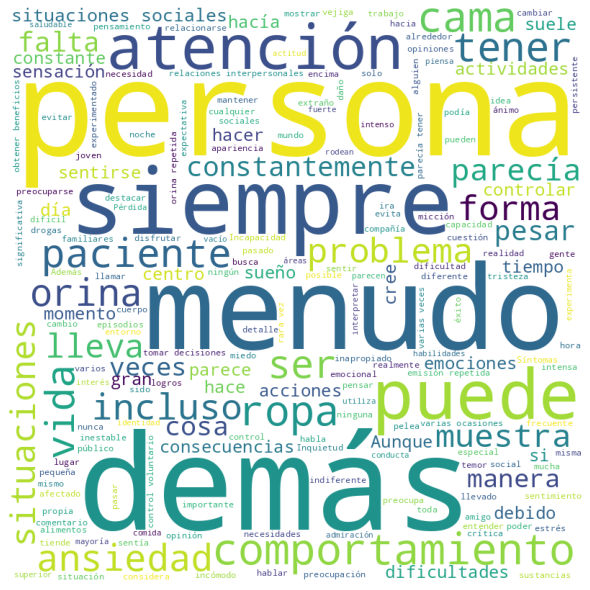

In [160]:
all_text = ' '.join(list(data["Síntoma"].values))
nube_palabras(all_text)
del all_text

In [114]:
dataset = Dataset.from_pandas(data)

In [115]:
dataset = dataset.rename_column("Síntoma", "text")
dataset = dataset.rename_column("Padecimiento_Cat", "label")
dataset = dataset.train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'Padecimiento', 'label'],
        num_rows: 651
    })
    test: Dataset({
        features: ['text', 'Padecimiento', 'label'],
        num_rows: 163
    })
})

In [116]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

In [102]:
model_id="dccuchile/bert-base-spanish-wwm-cased"

In [103]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [104]:
def tokenize_function(examples):
  return tokenizer(examples["text"], padding="max_length", truncation=True)

In [105]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/651 [00:00<?, ? examples/s]

Map:   0%|          | 0/163 [00:00<?, ? examples/s]

In [118]:
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=target_nro, id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

In [117]:
metric = load_metric("accuracy")

In [119]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

In [120]:
from transformers import TrainingArguments
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [121]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)

In [122]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.762734,0.773006
2,No log,0.415547,0.883436
3,No log,0.384612,0.889571


TrainOutput(global_step=246, training_loss=0.6663769977848705, metrics={'train_runtime': 194.989, 'train_samples_per_second': 10.016, 'train_steps_per_second': 1.262, 'total_flos': 513915869279232.0, 'train_loss': 0.6663769977848705, 'epoch': 3.0})

In [123]:
trainer.evaluate(tokenized_datasets["test"])

{'eval_loss': 0.3846117854118347,
 'eval_accuracy': 0.8895705521472392,
 'eval_runtime': 5.1056,
 'eval_samples_per_second': 31.926,
 'eval_steps_per_second': 4.113,
 'epoch': 3.0}

In [124]:
model_id_custom = "./diagnotico_fine_tunning_transformer"
# Save tokenizer
tokenizer.save_pretrained(model_id_custom)
# Save model
trainer.save_model(model_id_custom)

In [125]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id_custom)
# Load model
loaded_model = AutoModelForSequenceClassification.from_pretrained(model_id_custom)

In [126]:
from transformers import pipeline

In [127]:
classifier = pipeline("text-classification", model=model_id_custom )

In [129]:
classifier("El paciente no come frente a mucha gente, y normalmente tiene miedo a usar camisa ajustada")

[{'label': 'Trastornos de la conducta alimentaria no especificados',
  'score': 0.9239223599433899}]

In [131]:
classifier("duerme tarde y se levanta con malhumor y le cuesta tratar bien a las personas")

[{'label': 'Trastorno Depresivo Mayor', 'score': 0.6187843680381775}]